In [68]:
import re
import itertools
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from tabulate import tabulate

## Fuzzificação

C:\Users\yvesa\miniconda3\envs\fuzzy\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


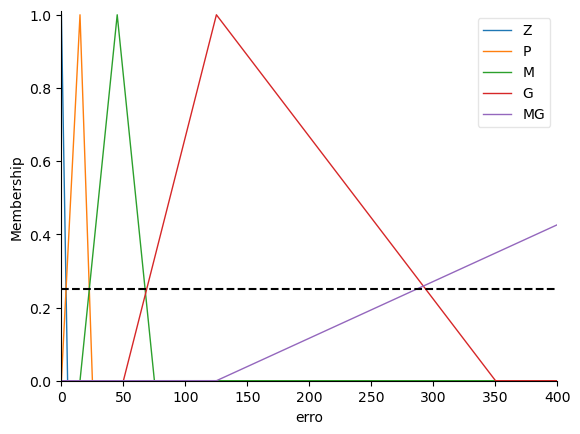

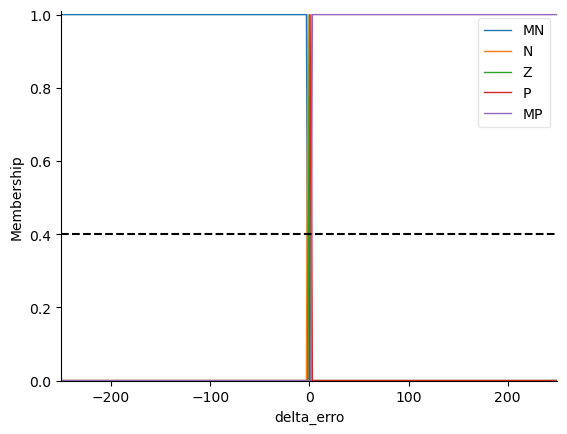

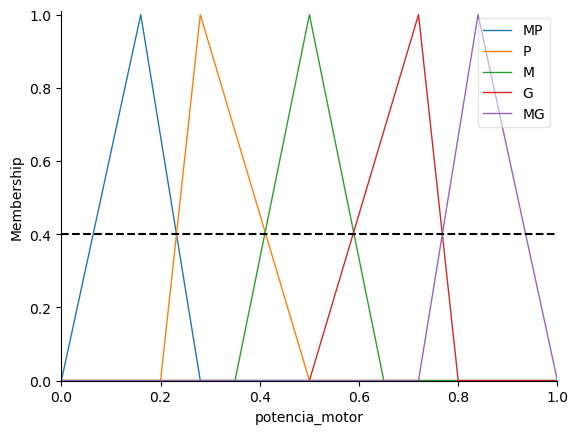

In [69]:
# Definindo os universos para as variáveis de entrada e saída
erro = ctrl.Antecedent(np.arange(0, 1000.1, 0.1), 'erro')
delta_erro = ctrl.Antecedent(np.arange(-1000, 1000.5, 0.5), 'delta_erro')
potencia_motor = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'potencia_motor')


# Definindo funções de pertinência para o erro
erro['Z'] = fuzz.trimf(erro.universe, [0, 0, 5])
erro['P'] = fuzz.trimf(erro.universe, [0, 15, 25])
erro['M'] = fuzz.trimf(erro.universe, [15, 45, 75])
erro['G'] = fuzz.trimf(erro.universe, [50, 125, 350])
erro['MG'] = fuzz.trimf(erro.universe, [125, 770, 1000]) # muito longe + descendo muito, - contrario

# Definindo funções de pertinência para delta_erro
delta_erro['MN'] = fuzz.trapmf(delta_erro.universe, [-1000, -1000, -3, -1.5])
delta_erro['N'] = fuzz.trimf(delta_erro.universe, [-3, -1.5, 0])
delta_erro['Z'] = fuzz.trimf(delta_erro.universe, [-1.5, 0, 1.5])
delta_erro['P'] = fuzz.trimf(delta_erro.universe, [0, 1.5, 3])
delta_erro['MP'] = fuzz.trapmf(delta_erro.universe, [1.5, 3, 1000, 1000])


# Definindo funções de pertinência para potencia_motor_direto e potencia_motor_reverso
potencia_motor['MP'] = fuzz.trimf(potencia_motor.universe, [0, 0.16, 0.28])
potencia_motor['P'] = fuzz.trimf(potencia_motor.universe, [0.2, 0.28, 0.5])
potencia_motor['M'] = fuzz.trimf(potencia_motor.universe, [0.35, 0.5, 0.65])
potencia_motor['G'] = fuzz.trimf(potencia_motor.universe, [0.5, 0.72, 0.8])
potencia_motor['MG'] = fuzz.trimf(potencia_motor.universe, [0.72, 0.84, 1])

erro.view()
plt.axline((0, 0.25), (1000, 0.25), color='black', linestyle='--')
plt.xlim(0, 400)

delta_erro.view()
plt.axline((0, 0.4), (1000, 0.4), color='black', linestyle='--')
plt.xlim(-250, 250)

potencia_motor.view()
plt.axline((0, 0.4), (1000, 0.4), color='black', linestyle='--')


## Base de Regras

In [70]:
# Criação das regras para o controle

result_potencia = [
    'MP', 'MP', 'M' , 'P' , 'M' ,
    'MP', 'P' , 'P' , 'M' , 'M' ,
    'P' , 'P' , 'M' , 'M' , 'G' ,
    'P' , 'M' , 'M' , 'G' , 'G' ,
    'M' , 'M' , 'G' , 'G' , 'MG',
]

BaseRegras = [
    ctrl.Rule(erro[Erro] & delta_erro[Delta_erro], potencia_motor[Potencia_motor])
    for (Erro, Delta_erro), Potencia_motor in
    zip(itertools.product(erro.terms.keys(), delta_erro.terms.keys()), result_potencia)
]

In [71]:
ciano = '\033[96m'  # Define a cor azul-ciano

tabela = []
for Erro in erro.terms:
  for Delta_erro in delta_erro.terms:
    for regra in BaseRegras:
      antecedente = str(regra).split('IF ')[1].split(' THEN')[0].replace('AND ', '')
      consequente = str(regra).split('IF ')[1].split(' THEN')[1].split('AND ')[0]

      classificacoes = re.findall(r'\[(.*?)\]', (antecedente + consequente))
      if Erro == classificacoes[0] and Delta_erro == classificacoes[1]:
        tabela.append([classificacoes[0], classificacoes[1], classificacoes[2]])
        break

df = pd.DataFrame(tabela, columns=[erro.label, delta_erro.label, potencia_motor.label])
pivotTable = pd.DataFrame(df.pivot(index=delta_erro.label, columns=erro.label, values=potencia_motor.label).reindex(index=delta_erro.terms, columns=erro.terms))
pivotTable.index.name = f'{ciano}{"E"}\033[0m'
print(tabulate(pivotTable, headers='keys', tablefmt='fancy_grid', stralign='center', showindex='always'))

╒═════╤═════╤═════╤═════╤═════╤══════╕
│  E  │  Z  │  P  │  M  │  G  │  MG  │
╞═════╪═════╪═════╪═════╪═════╪══════╡
│ MN  │ MP  │ MP  │  P  │  P  │  M   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  N  │ MP  │  P  │  P  │  M  │  M   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  Z  │  M  │  P  │  M  │  M  │  G   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  P  │  P  │  M  │  M  │  G  │  G   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│ MP  │  M  │  M  │  G  │  G  │  MG  │
╘═════╧═════╧═════╧═════╧═════╧══════╛


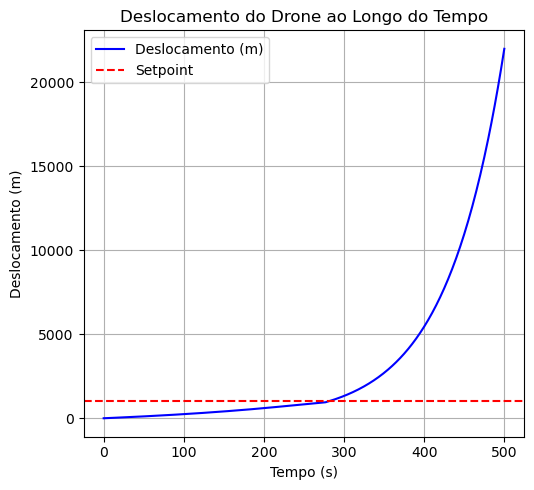

In [74]:
setpoint = 1000  # Altitude desejada (em metros)
d_t_minus_1 = 1  # posição atual do drone, em metros
tempo = 500  # Tempo de simulação (em segundos)
dt = 1  # Intervalo de tempo (em segundos)

# Parâmetros do sistema fuzzy
FA = 1  # Fator de Ajuste
U_max = 4  # Velocidade máxima de descida (m/s)

# Configurando o sistema de controle
ControleErro = ctrl.ControlSystemSimulation(ctrl.ControlSystem(BaseRegras))

# Definindo entradas para Erro e DeltaErro
ControleErro.input[erro.label] = 5  # valor desejado para Erro
ControleErro.input[delta_erro.label] = 4  # valor desejado para DeltaErro

# Realiza o cálculo do sistema fuzzy
ControleErro.compute()

# Valores para armazenar deslocamentos e erros
deslocamentos = [d_t_minus_1]
erros = [setpoint - d_t_minus_1]

for t in range(1, tempo + 1):
    # Calcular o erro
    erro_atual = setpoint - d_t_minus_1
    erros.append(erro_atual)
    
    FA = 99/100 if erro_atual > 50 else 1

    delta_erro_atual = (erros[-1] - erros[-2]) / dt  # Taxa de variação do erro

    # Configurar entradas do sistema fuzzy
    ControleErro.input['erro'] = erro_atual
    ControleErro.input['delta_erro'] = delta_erro_atual

    # Realizar o cálculo fuzzy
    ControleErro.compute()
    
      # Obter a saída defuzzyficada (potência do motor)
    P_Motor = ControleErro.output['potencia_motor']

    # Divisão da potência entre os motores
    P_H13 = P_Motor
    P_H24 = P_Motor

    # Atualizar o deslocamento com a função de transferência
    d_t = FA * d_t_minus_1 * 1.01398 + (0.5 * (U_max * P_H13 + U_max * P_H24))
    deslocamentos.append(d_t)

    # Atualizar o deslocamento anterior
    d_t_minus_1 = d_t

# Gráficos
plt.figure(figsize=(10, 5))

# Gráfico do deslocamento
plt.subplot(1, 2, 1)
plt.plot(range(len(deslocamentos)), deslocamentos, label='Deslocamento (m)', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label='Setpoint')
plt.xlabel('Tempo (s)')
plt.ylabel('Deslocamento (m)')
plt.title('Deslocamento do Drone ao Longo do Tempo')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Simulação do Controle

In [73]:
# Configurando os sistemas de controle fuzzy para cada par de motores
controle_direto = ctrl.ControlSystem([rule1_direto, rule2_direto, rule3_direto, rule4_direto, rule5_direto, rule6_direto])
controle_reverso = ctrl.ControlSystem([rule1_reverso, rule2_reverso, rule3_reverso, rule4_reverso, rule5_reverso, rule6_reverso])

simulacao_direto = ctrl.ControlSystemSimulation(controle_direto)
simulacao_reverso = ctrl.ControlSystemSimulation(controle_reverso)

# Parâmetros de simulação
Umáx = 4  # Velocidade máxima de descida no S-mode (m/s)
d_altura = 100  # Altura inicial do drone (exemplo)
tempo = np.arange(0, 400, 1)

# Lista para armazenar as alturas ao longo do tempo
alturas = [d_altura]

# Simulação de controle ao longo do tempo
for i in tempo:

SyntaxError: incomplete input (1262349294.py, line 17)

# Considerações com Base no Enunciado
1.  Variação Máxima de Saída no Modo S-mode: O enunciado especifica uma velocidade máxima de descida (Umáx) de 4 m/s no S-mode. Essa velocidade máxima limita o quanto o drone pode descer por ciclo de tempo, o que representa o teto para a saída da potência.

2. Erro e Delta de Erro: Vamos definir o erro como uma variável que pode ser apenas positiva, representando a diferença entre a altura atual do drone e o ponto de referência (setPoint). Isso permite que o controle ajuste a velocidade de descida sempre em direção ao ponto alvo.

3. Controle Direto e Reverso em Pares de Motores: Os motores operam em pares e são ajustados por duas bases de regras, uma para o controle direto e outra para o controle reverso, que alternam a intensidade do ajuste para minimizar o erro.

# Construindo a Função de Transferência
Com essas definições, a função de transferência será usada para calcular a potência dos motores de forma proporcional ao erro e ao delta de erro, considerando a variação máxima de saída permitida no modo S-mode (4 m/s), adaptamos a função de transferência para ajustar a saída do controle fuzzy, sem precisar calcular um deslocamento acumulativo. Em vez disso, limitamos a resposta do controle à velocidade máxima permitida.